# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
clase = 2
root_dir = "/content/drive/My Drive/"
project_dir = "RRNN_PxQ/Clase_" + str(clase) + "/Práctica/"
os.chdir(root_dir + project_dir)

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

# Redes Convolucionales 1D

In [4]:
# Cargo los datos
dataset = "co2_emissions_4countries.csv"
dataset_path=os.path.join("datasets_clasificacion",dataset)
data=pd.read_csv(dataset_path)
#np.loadtxt(open(dataset_path, "rb"), delimiter=",", skiprows=1)

In [ ]:
data.head()

,year,canada,germany,poland,uk,us
0,1800,0.00733,0.0442,0.0452,2.48,0.0422
1,1801,0.00716,0.0293,0.0489,2.46,0.0438
2,1802,0.00698,0.0298,0.0494,2.45,0.0465
3,1803,0.00681,0.0283,0.0502,2.72,0.0468
4,1804,0.00665,0.0525,0.0495,2.70,0.0516


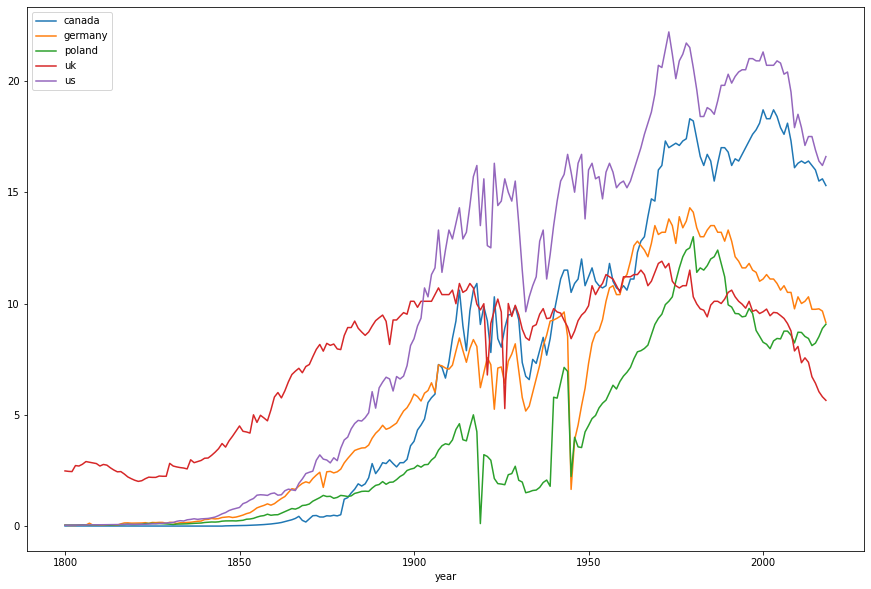

In [ ]:
data.set_index('year').plot(subplots=False, figsize=(15, 10)); plt.legend(loc='best')

In [36]:
data_dif = data
data_dif[['canada', 'germany', 'poland', 'uk', 'us']] = data[['canada', 'germany', 'poland', 'uk', 'us']].diff()
data_dif = data_dif.loc[1:,]
data_dif.head()


,year,canada,germany,poland,uk,us
1,1801,-0.00017,-0.0149,0.0037,-0.02,0.0016
2,1802,-0.00018,0.0005,0.0005,-0.01,0.0027
3,1803,-0.00017,-0.0015,0.0008,0.27,0.0003
4,1804,-0.00016,0.0242,-0.0007,-0.02,0.0048
5,1805,-0.00016,0.0009,0.0118,0.08,0.0001


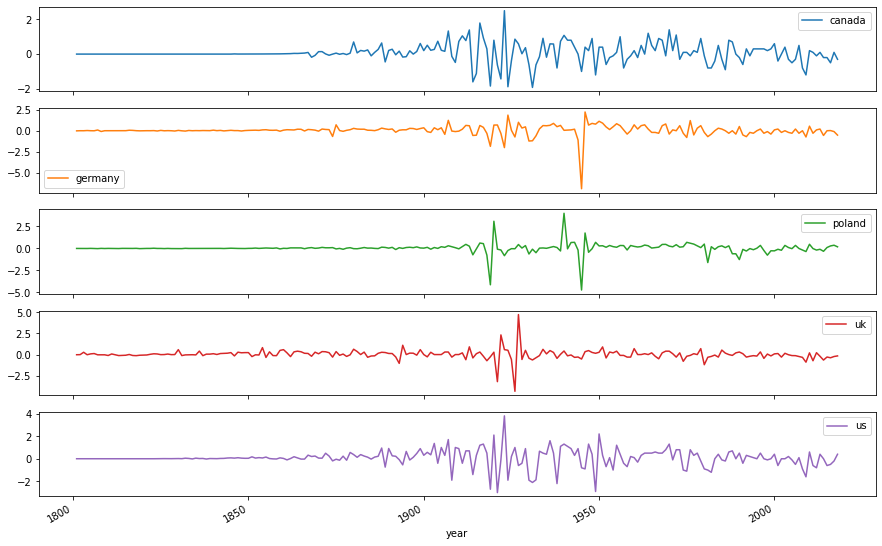

In [ ]:
data_dif.set_index('year').plot(subplots=True, figsize=(15, 10)); plt.legend(loc='best')

In [ ]:
# Las convoluciones pueden ser regulares o causales.
# Una convolución causal (y/o un filtro convolucional causal) es una convolución que tiene en cuenta la estructura temporal de los datos
# (asumiendo que la hay), y solamente considera para la convolución aquellas instancias en un tiempo anterior.

# Documentación de convoluciones en Keras: https://keras.io/api/layers/convolution_layers/convolution1d/ 

In [ ]:
# Convolución estándar
%%html
<iframe src="https://drive.google.com/file/d/13Nodj_auH-wsj-tXYgTTb8keyYIhu2Qx/preview" width="640" height="480"></iframe>

In [ ]:
# Convolución causal (dilatada):
%%html
<iframe src="https://drive.google.com/file/d/1TSnBmPH4TdOCJh8hiLR3u87oNL2mL4tC/preview" width="640" height="480"></iframe>

# Emisiones de Carbono


Necesitamos primero tener en claro el objetivo: vamos a predecir, usando data de 8 años, el año 9.

Necesitamos una función que tome un vector y lo preprocese de forma que podamos usarlo para la predicción.

In [5]:
def vec_to_train(vector_obs, train_size = 8, prediction_window = 0):
  x_train = []
  y_train = []
  vector_obs = list(vector_obs)
  n_obs = len(vector_obs)
  i=0
  while i < n_obs-prediction_window-train_size:
    obs_x = vector_obs[i:i+train_size]
    obs_y = vector_obs[i + train_size + prediction_window]
    x_train.append(obs_x)
    y_train.append(obs_y)
    i += 1
  return np.array(x_train), np.array(y_train)

# En este caso la ventana de predicción es cero porque queremos predecir el valor inmediatamente siguiente. 

Vamos a preparar entonces el modelo haciendo el split train / test

Hay varias formas de hacer esto: primero el split y despues preprocesar, o preprocesar y después hacer el split. 

En este segundo caso hay que tener cuidado de solo hacer preprocesamientos que no permitan al algoritmo ver los datos.

Al no haber diferenciado no hay problema en este caso de hacer un split posterior

In [37]:
x_data, y_data = vec_to_train(data['uk'])

porc_split = 0.7
index_split = int(np.floor(len(x_data)*0.7))

x_train = x_data[0:index_split]
x_test = x_data[index_split:]
y_train = y_data[0:index_split]
y_test = y_data[index_split:]

In [39]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [ ]:
# Vamos a retomar primero el modelo secuencial de la vez pasada:
# modelo = keras.Sequential([
#    keras.layers.Dense(3,input_shape=(d_in,), activation='relu'),
#    keras.layers.Dense(5, activation='tanh'),
#    keras.layers.Dense(classes, activation='softmax')])

#Este modelo tiene algunos problemas con respecto a lo que queremos resolver, porque ya no tenemos más clases
#Tenemos que modificarlo para predecir valores, y agregarle las capas convolucionales:

d_in = 8

modelo = keras.Sequential([
    keras.layers.Conv1D(filters = 8, kernel_size = 4, activation='relu', padding= 'causal', input_shape = (d_in,1)),
    keras.layers.Conv1D(filters = 16, kernel_size = 2, padding= 'valid', activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1)])

modelo.compile( 
  optimizer='adam', 
  loss='mean_squared_error',
  metrics = 'mae'
  )


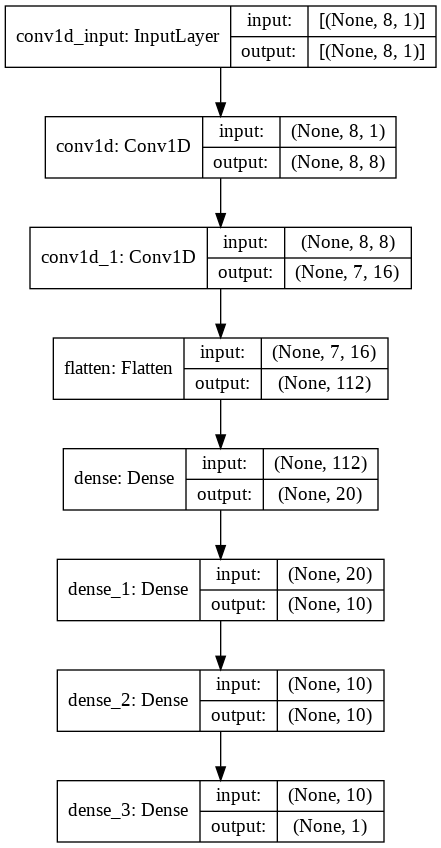

In [ ]:
#Visualicemos el modelo: 
tf.keras.utils.plot_model(modelo, show_shapes=True)

In [ ]:
# Y veamos su summary
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 8, 8)              40        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 16)             272       
_________________________________________________________________
flatten (Flatten)            (None, 112)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                2260      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [ ]:
batch_size = 40
epochs = 300

history = modelo.fit( 
    x= x_train,
    y=y_train,
    epochs=epochs,
    batch_size= batch_size
)

Epoch 1/300
4/4 [==============================] - 0s 3ms/step - loss: 0.4181 - mae: 0.4311
Epoch 2/300
4/4 [==============================] - 0s 3ms/step - loss: 0.4221 - mae: 0.4091
Epoch 3/300
4/4 [==============================] - 0s 4ms/step - loss: 0.4239 - mae: 0.4133
Epoch 4/300
4/4 [==============================] - 0s 4ms/step - loss: 0.4132 - mae: 0.4201
Epoch 5/300
4/4 [==============================] - 0s 3ms/step - loss: 0.4231 - mae: 0.4011
Epoch 6/300
4/4 [==============================] - 0s 6ms/step - loss: 0.4144 - mae: 0.4119
Epoch 7/300
4/4 [==============================] - 0s 5ms/step - loss: 0.4079 - mae: 0.4203
Epoch 8/300
4/4 [==============================] - 0s 4ms/step - loss: 0.4207 - mae: 0.3957
Epoch 9/300
4/4 [==============================] - 0s 5ms/step - loss: 0.4051 - mae: 0.4015
Epoch 10/300
4/4 [==============================] - 0s 6ms/step - loss: 0.4187 - mae: 0.4370
Epoch 11/300
4/4 [==============================] - 0s 4ms/step - loss: 0.4055 

In [ ]:
yhat = modelo.predict(x_test, verbose=0)

el MSE es 0.20461596842783872, y el RMSE es 0.4523449661793958


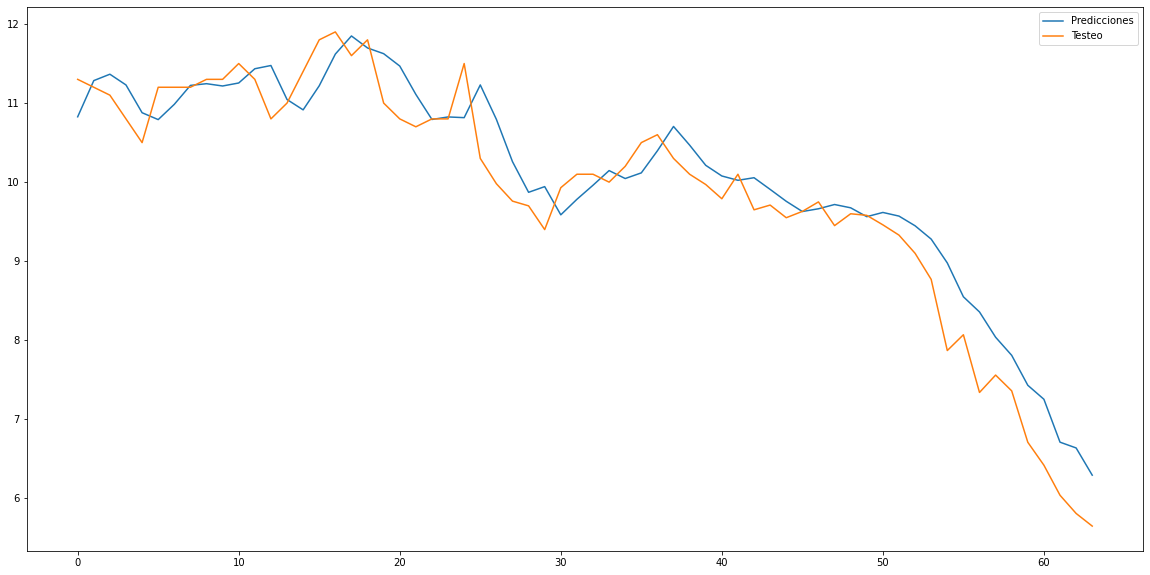

In [ ]:
def unpack_yhat(yhat):
  hat = []
  for i in range(len(yhat)):
    hat.append(yhat[i][0])
  return (hat)

yhat = unpack_yhat(yhat)

mse = np.mean((yhat-y_test)**2)
rmse = np.sqrt(mse)
print(f"el MSE es {mse}, y el RMSE es {rmse}")

plt.figure(figsize=(20,10))
ds1 = pd.Series(yhat)
ds2 = pd.Series(y_test)
plt.plot(ds1, label='Predicciones')
plt.plot(ds2, label='Testeo')
plt.legend()
plt.show()

# Entrenar modelos temporales con Cross Validation

Vamos a entrenar el modelo ahora con un conjunto de validación que tenga en cuenta la división temporal de nuestros datos.

In [ ]:
# Defino el modelo nuevamente para entrenar desde 0:
d_in = 8

modelo = keras.Sequential([
    keras.layers.Conv1D(filters = 8, kernel_size = 4, activation='relu', padding= 'causal', input_shape = (d_in,1)),
    keras.layers.Conv1D(filters = 16, kernel_size = 2, padding= 'valid', activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1)])

modelo.compile( 
  optimizer='adam', 
  loss='mean_squared_error',
  metrics = 'mae'
  )

In [8]:
tss = TimeSeriesSplit(n_splits=5)

In [ ]:
for train_index, val_index in tss.split(x_train):
  print("TRAIN:", train_index, "VALIDATION:", val_index)

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] VALIDATION: [27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50] VALIDATION: [51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74] VALIDATION: [75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79

In [ ]:
batch_size = 40
epochs = 300

fold_loss = []
fold_mae = []

fold_no = 1

for train_index, test_index in tss.split(x_train):
  print('------------------------------------------------------------------------')
  print(f'Entrenando Fold {fold_no}.')
  modelo.fit( 
    x= x_train[train_index],
    y= y_train[train_index],
    epochs=epochs,
    batch_size= batch_size,
    verbose = 0,
    validation_data = (x_train[test_index], y_train[test_index]))
  scores = modelo.evaluate(x_train[test_index], y_train[test_index], verbose=0)
  fold_loss.append(scores[0])
  fold_mae.append(scores[1])
  print(f'Fin Fold {fold_no}.')
  fold_no += 1

------------------------------------------------------------------------
Entrenando Fold 1.
Fin Fold 1.
------------------------------------------------------------------------
Entrenando Fold 2.
Fin Fold 2.
------------------------------------------------------------------------
Entrenando Fold 3.
Fin Fold 3.
------------------------------------------------------------------------
Entrenando Fold 4.
Fin Fold 4.
------------------------------------------------------------------------
Entrenando Fold 5.
Fin Fold 5.


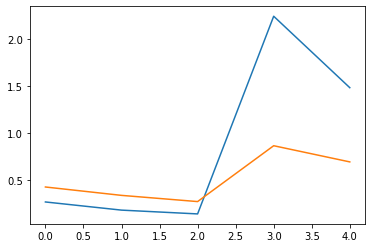

In [ ]:
plt.plot(fold_loss, label='Loss')
plt.plot(fold_mae, label='MAE')
plt.show()

el MSE es 0.3995559321348199, y el RMSE es 0.6321043680713019


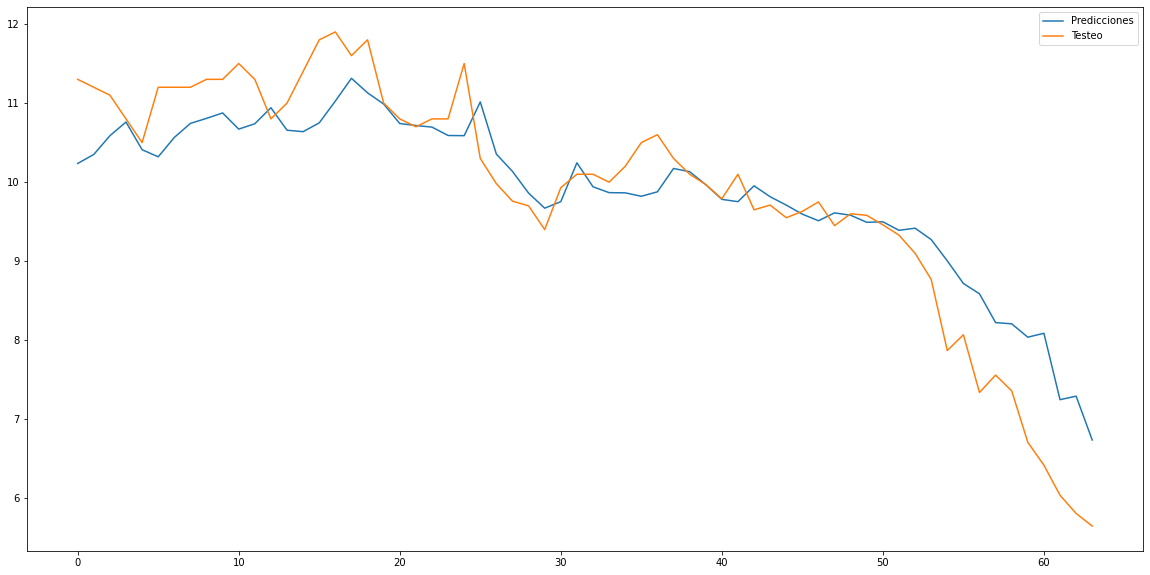

In [ ]:
yhat = modelo.predict(x_test, verbose=0)
yhat = unpack_yhat(yhat)

mse = np.mean((yhat-y_test)**2)
rmse = np.sqrt(mse)
print(f"el MSE es {mse}, y el RMSE es {rmse}")

plt.figure(figsize=(20,10))
ds1 = pd.Series(yhat)
ds2 = pd.Series(y_test)
plt.plot(ds1, label='Predicciones')
plt.plot(ds2, label='Testeo')
plt.legend()
plt.show()